In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import tensorflow as tf
import os 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

2023-05-01 19:33:57.349433: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 19:34:00.640447: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-05-01 19:34:00.640569: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-05-01 19:34:00.640574: W tensorfl

In [2]:
def create_dataset(dataset, look_back=1):
    #Sotre input and target Data 
    data_x, data_y = [], []
    
    # Loop through the dataset, leaving out the last 'look_back' data points
    for i in range(len(dataset) - look_back):
        data_x.append(dataset[i:(i + look_back), 0])
        data_y.append(dataset[i + look_back, 0])
        
    # Convert the lists of input and target data 
    return np.array(data_x), np.array(data_y)

In [3]:
def load_and_preprocess_data(file_name):
    # Load data from the given file into a pandas DataFrame
    df = pd.read_csv(file_name)

    # Filter data for the country Sweden
    df = df[df['COUNTRY_AREA_TERRITORY'] == 'China']

    df_agg = df.groupby(['ISO_YEAR', 'ISO_WEEKSTARTDATE']).agg({'INF_ALL': 'sum', 'INF_A': 'sum', 'INF_B': 'sum'}).reset_index()
    df_agg['ISO_WEEKSTARTDATE'] = pd.to_datetime(df_agg['ISO_WEEKSTARTDATE'])

    # Set the index to be the date
    df_agg.set_index('ISO_WEEKSTARTDATE', inplace=True)
    
    df_agg = df_agg[df_agg.index >= '2008-1-31']
    # Filter data up to December 31, 2020
    df_agg = df_agg[df_agg.index <= '2019-12-31']

    return df_agg['INF_ALL']

In [4]:
def train_lstm_model(data, look_back, epochs, batch_size):
    # Reshape and normalize the data
    data = np.array(data).reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)

    # Split the dataset into train and test sets
    train_size = int(len(data) * 0.8)
    train, test = data[:train_size], data[train_size:]

    # Create the datasets with the specified look_back
    train_x, train_y = create_dataset(train, look_back)
    test_x, test_y = create_dataset(test, look_back)

    # Reshape the input to be [samples, time steps, features]
    train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
    test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(100, input_shape=(1, look_back)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')

    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_x, test_y), verbose=0)

    # Make predictions
    train_predict = model.predict(train_x)
    test_predict = model.predict(test_x)

    # Invert predictions and target values to their original scale
    train_predict = scaler.inverse_transform(train_predict)
    train_y = scaler.inverse_transform(train_y.reshape(-1, 1))
    test_predict = scaler.inverse_transform(test_predict)
    test_y = scaler.inverse_transform(test_y.reshape(-1, 1))

    return model, scaler, train_predict, test_predict, train_y, test_y

In [5]:
def visualize_data_and_forecast(data, train_predict, test_predict, look_back):
    plt.figure(figsize=(12, 6))
    plt.plot(data, label='Original Data')
    plt.plot(data.index[look_back:len(train_predict) + look_back], train_predict, label='Train Predictions')
    plt.plot(data.index[len(train_predict) + 2*look_back:], test_predict.flatten(), label='Test Predictions')
    plt.xlabel('Weeks')
    plt.ylabel('Influenza Cases')
    plt.title('China Influenza Cases Forecast with LSTM')
    plt.legend()
    plt.show()

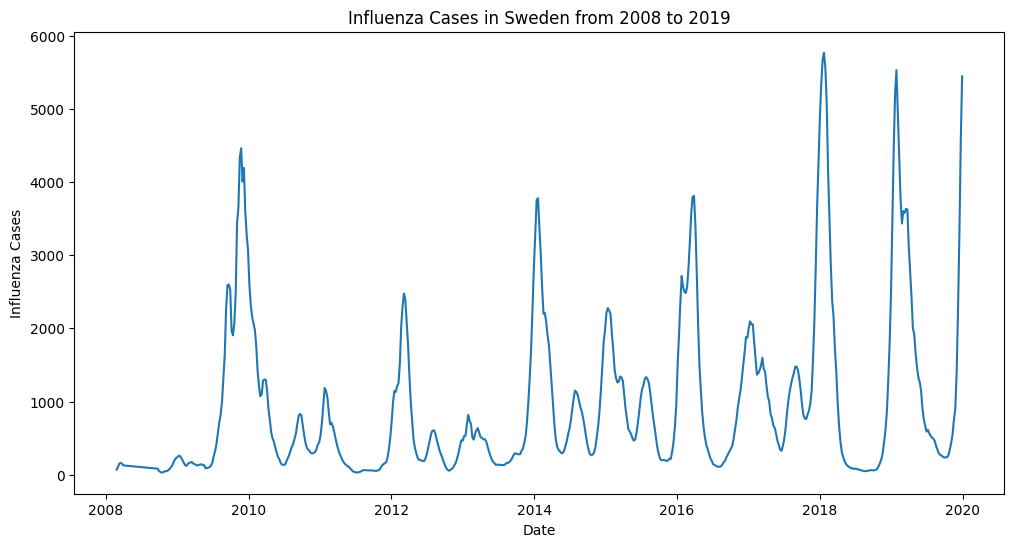

In [6]:
file_name = 'VIW_FNT.csv'

data = load_and_preprocess_data(file_name)
data = data.rolling(window=4).mean().dropna()

# Plot the data and seasonal decomposition
plt.figure(figsize=(12, 6))
plt.plot(data)
plt.xlabel('Date')
plt.ylabel('Influenza Cases')
plt.title('Influenza Cases in Sweden from 2008 to 2019')
plt.show()


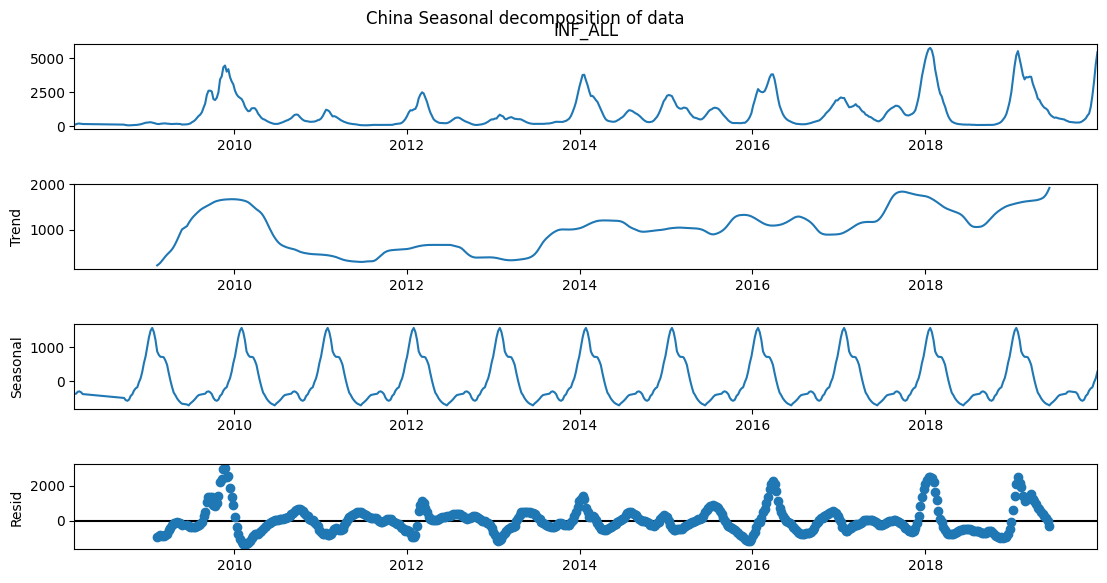

In [7]:
decomposition = seasonal_decompose(data, period=52)
fig = decomposition.plot()
fig.set_size_inches(12, 6)
fig.suptitle("China Seasonal decomposition of data")
plt.show()

2/2 [==============================] - 0s 3ms/step


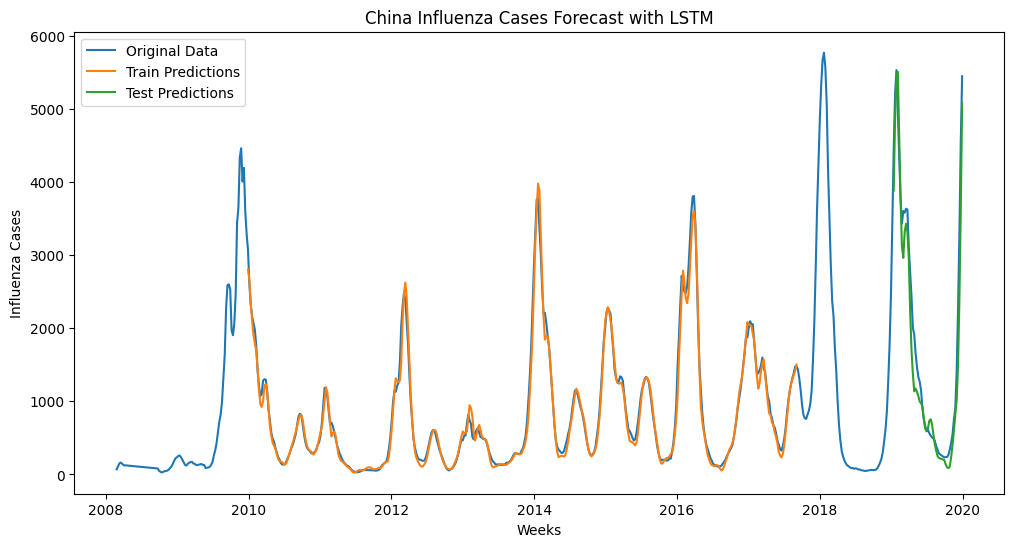

In [8]:
# Train the LSTM model
look_back = 70
epochs = 150
batch_size = 64
lstm_model, scaler, train_predict, test_predict, train_y, test_y = train_lstm_model(
    data, look_back, epochs, batch_size
)
# Visualize the data and forecast
visualize_data_and_forecast(data, train_predict, test_predict, look_back)

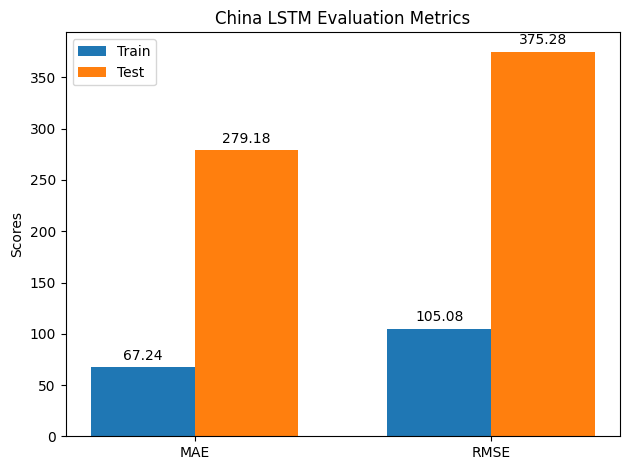

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Calculate evaluation metrics
train_mae = mean_absolute_error(train_y, train_predict)
train_rmse = np.sqrt(mean_squared_error(train_y, train_predict))

test_mae = mean_absolute_error(test_y, test_predict)
test_rmse = np.sqrt(mean_squared_error(test_y, test_predict))

# Define the metrics
metrics = ['MAE', 'RMSE']
train_values = [train_mae, train_rmse]
test_values = [test_mae, test_rmse]

# Set up the bar graph
x = np.arange(len(metrics))
bar_width = 0.35

fig, ax = plt.subplots()
train_bars = ax.bar(x - bar_width/2, train_values, bar_width, label='Train')
test_bars = ax.bar(x + bar_width/2, test_values, bar_width, label='Test')

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('Scores')
ax.set_title('China LSTM Evaluation Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add text labels above the bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('%.2f' % height,
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(train_bars)
autolabel(test_bars)

fig.tight_layout()
plt.show()


In [10]:
def predict_future(model, scaler, data, look_back, num_weeks):
    future_predictions = []
    input_data = data[-look_back:]

    for _ in range(num_weeks):
        input_data_scaled = scaler.transform(input_data.reshape(-1, 1))
        input_data_reshaped = np.reshape(input_data_scaled, (1, 1, look_back))
        prediction = model.predict(input_data_reshaped,verbose=0)
        prediction_rescaled = scaler.inverse_transform(prediction)
        
        # Clip the prediction to a minimum value of 0 and a maximum value of 3200
        prediction_clipped = np.clip(prediction_rescaled, 0, 5600)
        
        future_predictions.append(prediction_clipped[0][0])
        input_data = np.append(input_data[1:], prediction_clipped)

    return future_predictions


# Make predictions for 2020 and 2021
num_weeks_2020_2021 = 52 * 3
future_predictions = predict_future(lstm_model, scaler, data.values, look_back, num_weeks_2020_2021)

# Convert the predictions to a pandas Series with a DateTimeIndex
prediction_dates = pd.date_range(start=data.index[-1] + pd.to_timedelta(7, unit='D'), periods=num_weeks_2020_2021, freq='W')
predicted_cases = pd.Series(future_predictions, index=prediction_dates)


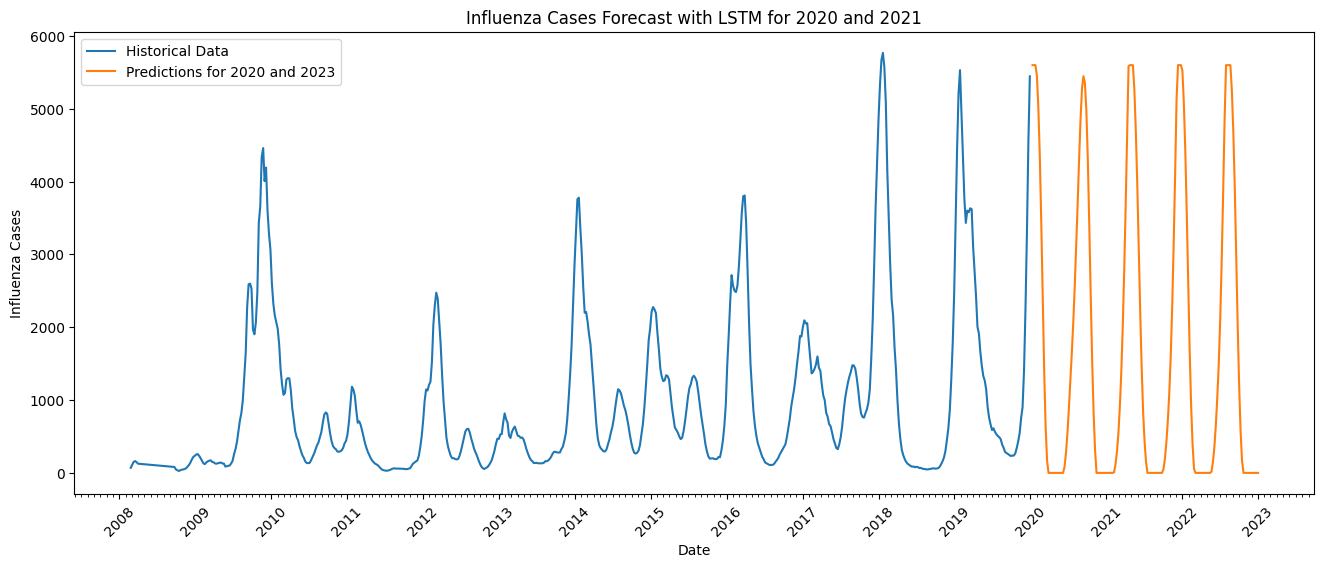

In [11]:
# Plot the predictions
plt.figure(figsize=(16, 6))
plt.plot(data, label='Historical Data')
plt.plot(predicted_cases, label='Predictions for 2020 and 2023')
plt.xlabel('Date')
plt.ylabel('Influenza Cases')
plt.title('Influenza Cases Forecast with LSTM for 2020 and 2021')
plt.legend()

# Set x-axis tick marks
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

plt.show()

# Convert the series to a dataframe
predicted_cases_df = predicted_cases.to_frame()

# Rename the column
predicted_cases_df.columns = ["INF_ALL"]

# Add 'Country' and 'Code' columns
predicted_cases_df['Country'] = 'China'
predicted_cases_df['Code'] = 'CHN'

# Convert the index to just date (no time)
predicted_cases_df.index = predicted_cases_df.index.date

# Reset the index to make 'Date' a column
predicted_cases_df.reset_index(inplace=True)

# Rename the index column to 'Date'
predicted_cases_df.rename(columns={'index': 'Date'}, inplace=True)

# Change date format to MM/DD/YYYY
predicted_cases_df['Date'] = predicted_cases_df['Date'].apply(lambda x: x.strftime('%m/%d/%Y'))

# Write the dataframe to an Excel file
predicted_cases_df.to_excel("forecasted_influenza_cases2.xlsx")

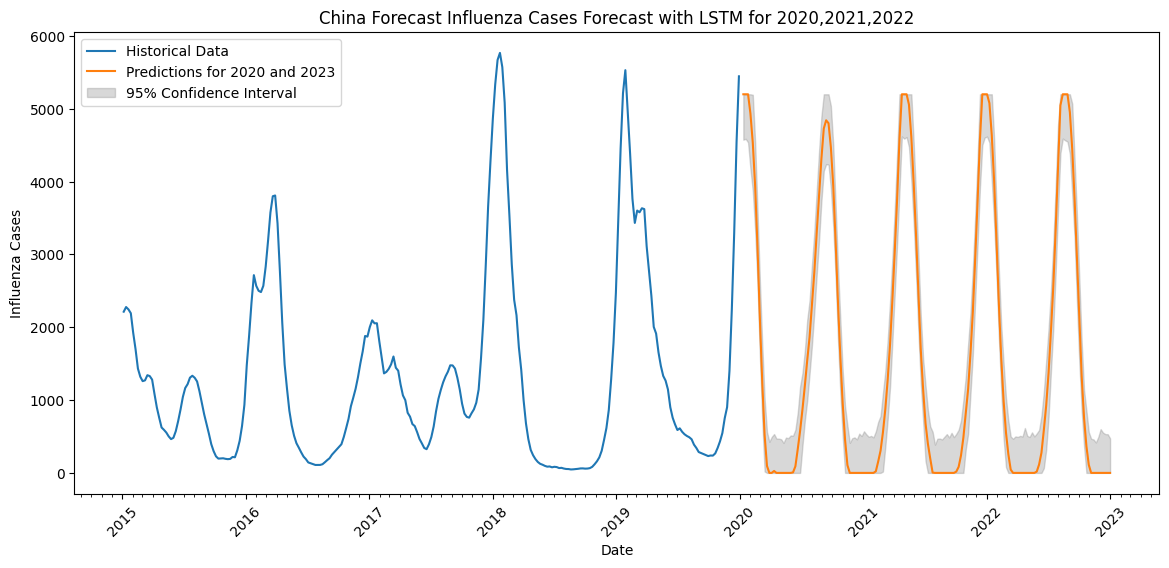

In [12]:
def predict_future(model, scaler, data, look_back, num_weeks, num_simulations=25, noise_std=0.05):
    future_predictions = []
    input_data = data[-look_back:]

    for _ in range(num_weeks):
        input_data_scaled = scaler.transform(np.array(input_data).reshape(-1, 1))
        
        # Run multiple simulations for the current prediction
        simulations = []
        for _ in range(num_simulations):
            noise = np.random.normal(0, noise_std, input_data_scaled.shape)
            input_data_reshaped = np.reshape(input_data_scaled + noise, (1, 1, look_back))
            prediction = model.predict(input_data_reshaped, verbose=0)
            prediction_rescaled = scaler.inverse_transform(prediction)
            simulations.append(prediction_rescaled[0][0])

        # Compute the mean and standard deviation of the simulations
        mean_prediction = np.mean(simulations)
        std_prediction = np.std(simulations)

        # Clip the prediction
        mean_prediction = np.clip(mean_prediction, 0, 5200)
        lower_bound = np.clip(mean_prediction - 1.96 * std_prediction, 0, 5200)
        upper_bound = np.clip(mean_prediction + 1.96 * std_prediction, 0, 5200)

        future_predictions.append((mean_prediction, lower_bound, upper_bound))
        input_data = np.append(input_data[1:], [mean_prediction])

    return future_predictions


# Make predictions for 2020 and 2021 with confidence intervals
num_weeks_2020_2021 = 52 * 3
num_simulations = 100  # Number of simulations to run for each prediction
future_predictions = predict_future(lstm_model, scaler, data, look_back, num_weeks_2020_2021, num_simulations)

# Plot the predictions with confidence intervals
plt.figure(figsize=(14, 6))
historical_data_from_2015 = data['2015':]
plt.plot(historical_data_from_2015.index, historical_data_from_2015, label='Historical Data')

mean_predictions = [pred[0] for pred in future_predictions]
lower_bounds = [pred[1] for pred in future_predictions]
upper_bounds = [pred[2] for pred in future_predictions]

plt.plot(prediction_dates, mean_predictions, label='Predictions for 2020 and 2023')
plt.fill_between(prediction_dates, lower_bounds, upper_bounds, color='gray', alpha=0.3, label='95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Influenza Cases')
plt.title('China Forecast Influenza Cases Forecast with LSTM for 2020,2021,2022')
plt.legend()

# Set x-axis tick marks
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

plt.show()
